In [1]:
import datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

/home/arnav/miniconda3/envs/DLA2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.load_dataset("wmt16","de-en", split="train[:50000]")
val_data = datasets.load_dataset("wmt16","de-en", split="validation")
test_data = datasets.load_dataset("wmt16","de-en", split="test")

In [3]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

50000
2169
2999


In [4]:
from torchtext.data.utils import get_tokenizer

tokenizer_german = get_tokenizer("spacy", language="de_core_news_sm")
tokenizer_english = get_tokenizer("spacy", language="en_core_web_sm")

In [5]:
# Set source and target languages
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders for the token transformers and vocabularies
token_transform = {SRC_LANGUAGE: tokenizer_german, TGT_LANGUAGE: tokenizer_english}
vocab_transform = {}

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [6]:
# Helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for data_sample in data_iter:
        yield token_transform[language](data_sample['translation'][language])

# Build vocabularies for both languages
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Directly passing the dataset to yield_tokens without using .map
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
    # Set UNK_IDX as the default index for vocabularies
    vocab_transform[ln].set_default_index(UNK_IDX)

In [7]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [8]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/home/arnav/miniconda3/envs/DLA2/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
from torch.nn.utils.rnn import pad_sequence

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        # Tokenize the source and target text samples
        src_tokens = tokenizer_german(src_sample)
        tgt_tokens = tokenizer_english(tgt_sample)
        
        # Numericalize tokens and append to respective batch lists
        src_batch.append(torch.tensor(vocab_transform[SRC_LANGUAGE](src_tokens), dtype=torch.long))
        tgt_batch.append(torch.tensor(vocab_transform[TGT_LANGUAGE](tgt_tokens), dtype=torch.long))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=False).to(DEVICE)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=False).to(DEVICE)

    # Create masks
    src_mask = generate_square_subsequent_mask(src_batch.size(0)).to(DEVICE)
    tgt_mask = generate_square_subsequent_mask(tgt_batch.size(0)).to(DEVICE)
    src_padding_mask = (src_batch == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt_batch == PAD_IDX).transpose(0, 1)
    memory_key_padding_mask = src_padding_mask.clone()

    return src_batch, tgt_batch, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask


from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]['translation'][SRC_LANGUAGE], self.data[idx]['translation'][TGT_LANGUAGE]

train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

Training:   0%|          | 0/782 [00:00<?, ?it/s]/home/arnav/miniconda3/envs/DLA2/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/arnav/miniconda3/envs/DLA2/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Evaluating: 100%|██████████| 34/34 [00:01<00:00, 28.04it/s]


Epoch 1, Train Loss: 5.943773217213428, Val Loss: 6.940455815371345


Evaluating: 100%|██████████| 34/34 [00:00<00:00, 35.59it/s]


Epoch 2, Train Loss: 4.94959748553498, Val Loss: 6.6814906316645


Evaluating: 100%|██████████| 34/34 [00:00<00:00, 35.54it/s]


Epoch 3, Train Loss: 4.532066992176768, Val Loss: 6.421237342497882


Evaluating: 100%|██████████| 34/34 [00:00<00:00, 35.54it/s]


Epoch 4, Train Loss: 4.1869426859004415, Val Loss: 6.298770343556123


Evaluating: 100%|██████████| 34/34 [00:00<00:00, 35.17it/s]


Epoch 5, Train Loss: 3.890337754698361, Val Loss: 6.183755047181073


Evaluating: 100%|██████████| 34/34 [00:00<00:00, 35.39it/s]


Epoch 6, Train Loss: 3.6323428172284684, Val Loss: 6.143365439246683


Evaluating: 100%|██████████| 34/34 [00:00<00:00, 35.61it/s]


Epoch 7, Train Loss: 3.406329569914152, Val Loss: 6.13268798940322


Evaluating: 100%|██████████| 34/34 [00:00<00:00, 35.35it/s]


Epoch 8, Train Loss: 3.204499813906677, Val Loss: 6.205365223043105


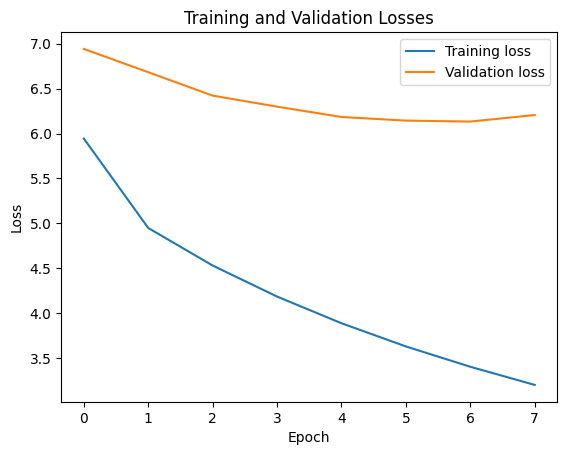

In [10]:
from tqdm import tqdm

def train_epoch(model, optimizer, dataloader, loss_fn, device):
    model.train()
    losses = 0
    for src, tgt, src_mask, _, src_padding_mask, _, memory_key_padding_mask in tqdm(dataloader, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)

        # Reduce the target sequence by 1 for the input to the decoder
        tgt_input = tgt[:-1, :]
        tgt_output = tgt[1:, :]  # This is used for loss calculation

        # Adjust the size of the target padding mask to match tgt_input
        tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
        
        # Regenerate tgt_mask to match the size of tgt_input
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(0)).to(device)

        # Ensure src_mask and memory_key_padding_mask are correctly sized and on the correct device
        src_mask = src_mask.to(device)
        memory_key_padding_mask = src_padding_mask.clone().to(device)  # Assuming src_padding_mask needs no adjustment

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)

        optimizer.zero_grad()

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(dataloader)


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    losses = 0
    with torch.no_grad():
        for src, tgt, src_mask, _, src_padding_mask, _, memory_key_padding_mask in tqdm(dataloader, desc="Evaluating"):
            src, tgt = src.to(device), tgt.to(device)
            
            # Reduce the target sequence by 1 for the input to the decoder
            tgt_input = tgt[:-1, :]
            tgt_output = tgt[1:, :]  # This is used for loss calculation

            # Adjust the size of the target padding mask to match tgt_input
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
            
            # Regenerate tgt_mask to match the size of tgt_input
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(0)).to(device)
            
            # Ensure src_mask and memory_key_padding_mask are correctly sized and on the correct device
            src_mask = src_mask.to(device)
            memory_key_padding_mask = src_padding_mask.clone().to(device)  # Assuming src_padding_mask needs no adjustment
            
            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
            
            tgt_out = tgt[1:, :]  # Already defined for clarity
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()
    
    return losses / len(dataloader)

NUM_EPOCHS = 8
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    train_loss = train_epoch(transformer, optimizer, train_dataloader, loss_fn, DEVICE)
    val_loss = evaluate(transformer, val_dataloader, loss_fn, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Plot the training and validation losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()


In [11]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    tokens = [BOS_IDX] + [vocab_transform[SRC_LANGUAGE][token] for token in tokenizer_german(src_sentence)] + [EOS_IDX]
    src = torch.tensor(tokens, dtype=torch.long).view(-1, 1).to(DEVICE)
    src_mask = (torch.zeros(len(tokens), len(tokens))).type(torch.bool).to(DEVICE)
    
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=len(tokens) + 5, start_symbol=BOS_IDX).flatten()
    
    return " ".join([vocab_transform[TGT_LANGUAGE].lookup_token(token) for token in tgt_tokens.cpu().numpy() if token not in (BOS_IDX, EOS_IDX, PAD_IDX)])

In [12]:
# Evaluate the model on the val set
val_inputs = [d['translation'][SRC_LANGUAGE] for d in val_data]
val_targets = [d['translation'][TGT_LANGUAGE] for d in val_data]
val_predictions = []

for inp in val_inputs:
    val_predictions.append(translate(transformer, inp))

# Evaluate the model on the test set
test_inputs = [d['translation'][SRC_LANGUAGE] for d in test_data]

targets = [d['translation'][TGT_LANGUAGE] for d in test_data]
predictions = []

for inp in test_inputs:
    predictions.append(translate(transformer, inp))

In [13]:
import sacrebleu
bleu_score = sacrebleu.corpus_bleu(predictions, [targets])

# Calculate METEOR score
import nltk
nltk.download('punkt')  # Make sure the tokenizer is downloaded
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score

meteor_scores = []

# Ensure that 'predictions' and 'targets' are lists of sentences
for i in range(len(predictions)):
    # Tokenize both the hypothesis (prediction) and the reference
    hypothesis_tokens = word_tokenize(predictions[i])
    reference_tokens = [word_tokenize(targets[i])]  # Note: reference needs to be a list of tokenized references
    
    # Calculate and append the METEOR score
    score = meteor_score(reference_tokens, hypothesis_tokens)
    meteor_scores.append(score)

average_meteor_score = sum(meteor_scores) / len(meteor_scores)


# Calculate BERTScore
from bert_score import score

P, R, F1 = score(predictions, targets, lang='en', verbose=True)

print("TEST DATA: ")
print(f"BLEU Score: {bleu_score.score}")
print(f"METEOR Score: {average_meteor_score}")
print(f"BERTScore-F1: {F1.mean()}")
print(f"BERTScore-Precision: {P.mean()}")
print(f"BERTScore-Recall: {R.mean()}")

[nltk_data] Downloading package punkt to /home/arnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 94/94 [00:10<00:00,  9.22it/s]


computing greedy matching.


100%|██████████| 47/47 [00:00<00:00, 140.40it/s]

done in 10.54 seconds, 284.57 sentences/sec
TEST DATA: 
BLEU Score: 0.5164618377756023
METEOR Score: 0.0841354560481469
BERTScore-F1: 0.7912341356277466
BERTScore-Precision: 0.7645007371902466
BERTScore-Recall: 0.8205881714820862


In [ ]:
# Save the model
torch.save(transformer.state_dict(), 'Setup2A_Model.pth')